In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import codecs
import gensim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from utils import display_text, clean_text, save_word2vec_tsv_format

In [4]:
# set params
WV_NAME = "OpenSubtitles"
VOCAB_SIZE = 50000

In [5]:
a = !wc -l datasets/open_subtitles/OpenSubtitles.en-pl.pl
FILE_PATH = "datasets/open_subtitles/OpenSubtitles.en-pl.pl"
TOTAL_LINE = int(a[0].split(" ")[0])
TOTAL_LINE

41998942

In [6]:
a = !wc -l datasets/paracrawl/ParaCrawl.en-pl.pl
FILE_PATH = "datasets/paracrawl/ParaCrawl.en-pl.pl"
TOTAL_LINE = int(a[0].split(" ")[0])
TOTAL_LINE

1275162

In [7]:
# before
display_text(FILE_PATH)

Koncertował na wielu polskich festiwalach jazzowych, a także za granicą m.in. w Kanadzie, Indonezji, Izraelu, Rosji i w większości krajów europejskich.

Presspack (PL)

Social media, jak skontaktować się z nami, z naszymi przyjaciółmi i znajomymi, dawnymi, obecnymi i przyszłymi gośćmi:

Dla dzieciaków XXI wieku:

więcej

O nas

To słowo przekazywane z ust do ust stworzyło tak naprawdę to miejsce i jesteśmy wdzięczni wszystkim tym, którzy budują tutejszy mikroświat i przyprowadzają ze sobą kolejnych, którzy są chętni dalej go współtworzyć.

Nagrodzeni przez:

Inne kluby w okolicy?

Wszystko to znajduje się w odległości kilkunastu minut piechotą od naszego hostelu. Natomiast historyczne centrum miasta, Mitte, z większością atrakcji turystycznych, znajduje się nieco dalej, około 5 minut jazdy transportem publicznym.



In [8]:
# clean text, get min_count
NEW_FILE_PATH = "_".join([FILE_PATH.split(".")[0],  "cleaned.txt"])
wordcounts = clean_text(FILE_PATH, NEW_FILE_PATH, total_line=TOTAL_LINE)
MIN_C = wordcounts.most_common(VOCAB_SIZE)[-1][1]

100%|██████████| 1275162/1275162 [00:24<00:00, 51998.04it/s]


In [9]:
# after
display_text(NEW_FILE_PATH)

koncertował na wielu polskich festiwalach jazzowych a także za granicą m in w kanadzie indonezji izraelu rosji i w większości krajów europejskich 

presspack pl 

social media jak skontaktować się z nami z naszymi przyjaciółmi i znajomymi dawnymi obecnymi i przyszłymi gośćmi 

dla dzieciaków xxi wieku 

więcej

o nas

to słowo przekazywane z ust do ust stworzyło tak naprawdę to miejsce i jesteśmy wdzięczni wszystkim tym którzy budują tutejszy mikroświat i przyprowadzają ze sobą kolejnych którzy są chętni dalej go współtworzyć 

nagrodzeni przez 

inne kluby w okolicy 

wszystko to znajduje się w odległości kilkunastu minut piechotą od naszego hostelu natomiast historyczne centrum miasta mitte z większością atrakcji turystycznych znajduje się nieco dalej około minut jazdy transportem publicznym 



In [10]:
# set params
WINDOW_SIZE = 3
EMB_DIM = 100
N_THREAD = 4

In [11]:
# build generator wrapper
def creator(self, file_path, window_size, total_line):
    self.file_path = file_path
    self.window_size = window_size
    self.total_line = total_line

def input_generator(self, ):
    with codecs.open(self.file_path, "r", 'utf-8') as f:
        for sent in tqdm(f, total=self.total_line):
            words = sent.split()
            if len(words) < self.window_size:
                continue
            yield words
                
sentences = type("Input_Class", (object,), {"__init__": creator, "__iter__": input_generator})

In [12]:
# train model and save results
model = gensim.models.Word2Vec(
    sentences=sentences(NEW_FILE_PATH, WINDOW_SIZE, total_line=TOTAL_LINE),
    window=WINDOW_SIZE,
    min_count=MIN_C,
    size=EMB_DIM,
    workers=N_THREAD
)
model.save("{}.bin".format(WV_NAME))
save_word2vec_tsv_format(model=model, file_name=WV_NAME)

100%|██████████| 50373/50373 [00:02<00:00, 17177.06it/s]


## Results

In [ ]:
# load model
model = gensim.models.KeyedVectors.load("{}.bin".format(WV_NAME))

In [13]:
from sklearn.manifold.t_sne import TSNE
def vis_emb(model, top_n=50, top_similar=10, figsize=(20, 20)):
    top_words=model.wv.index2word[100:100+top_n]
    top_words=np.append(np.array(top_words),np.array([np.array(model.most_similar_cosmul(w, topn=top_similar))
                                                      [:, 0] for w in top_words])).flatten()
    top_words=set(top_words)
    word_weights=[model.wv.word_vec(w, use_norm=False) for w in top_words]
    word_indexes=list(top_words)
    
    tsne = TSNE(n_components=2)
    wv_2 = tsne.fit_transform(word_weights)
    plt.figure(figsize=figsize)
    for i, word in enumerate(wv_2):
        plt.scatter(wv_2[i][0], wv_2[i][1]);
        plt.annotate(word_indexes[i], wv_2[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


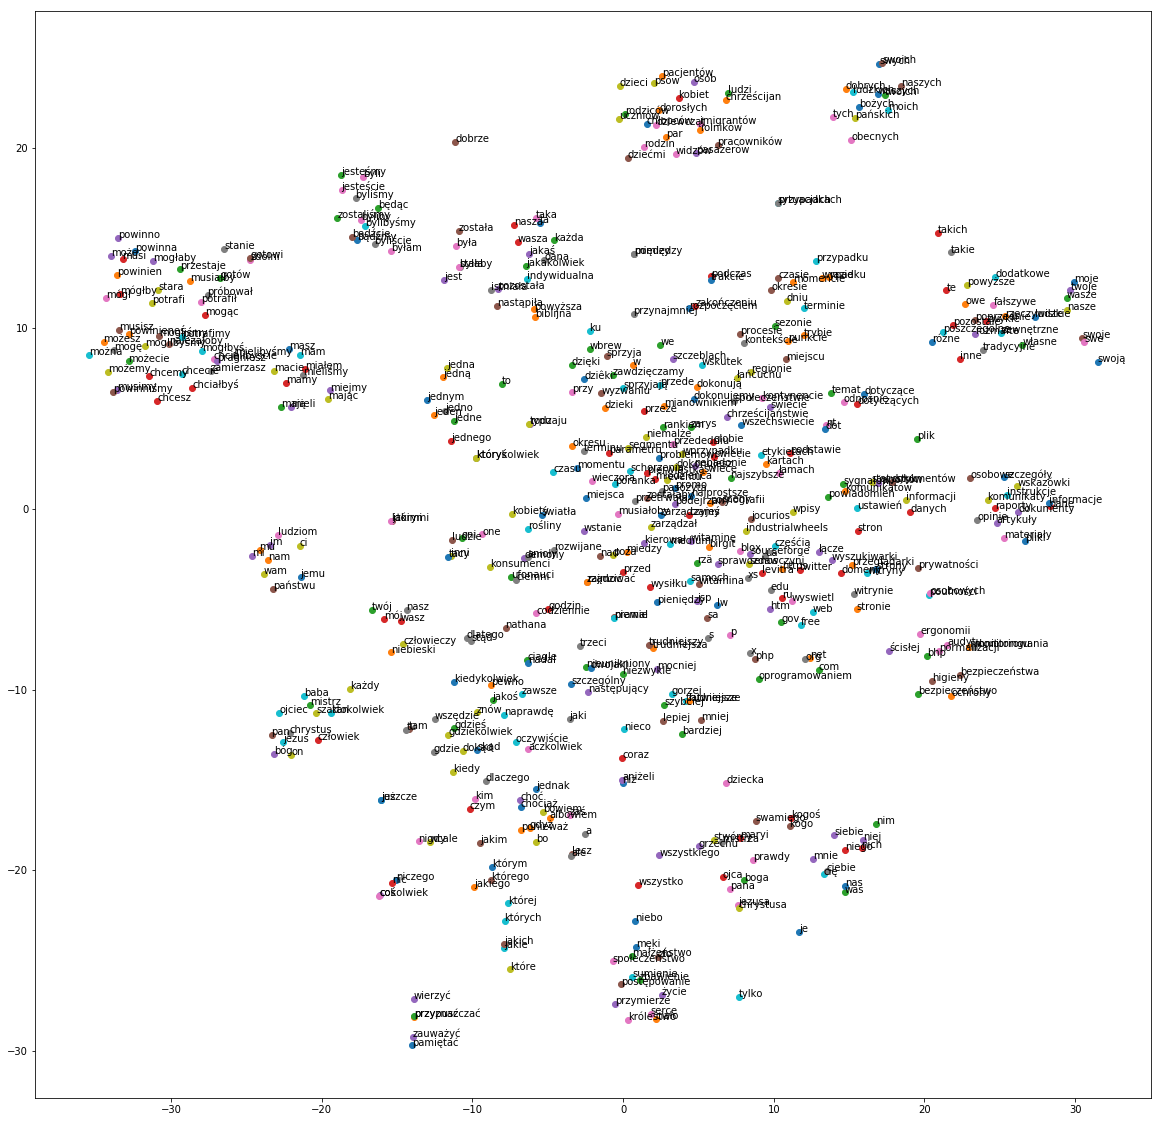

In [14]:
vis_emb(model)

In [15]:
model.most_similar(positive=['kobieta', 'król'], negative=['mężczyzna'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('nathan', 0.7022949457168579),
 ('papież', 0.664238691329956),
 ('mistrz', 0.6638756990432739),
 ('adam', 0.6581556797027588),
 ('piłat', 0.6568864583969116),
 ('józef', 0.6484006643295288),
 ('syn', 0.6468068361282349),
 ('chrystus', 0.6425012350082397),
 ('mesjasz', 0.6376248002052307),
 ('matka', 0.6373016834259033)]

In [16]:
model.most_similar_cosmul(positive=['kobieta', 'brat'], negative=['mężczyzna'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('siostra', 0.8774290680885315),
 ('babcia', 0.869633674621582),
 ('mama', 0.857941210269928),
 ('matka', 0.8470996618270874),
 ('dziewczyna', 0.8390944004058838),
 ('córka', 0.8378378748893738),
 ('książka', 0.8375728726387024),
 ('żona', 0.8327388167381287),
 ('chłopiec', 0.8218544125556946),
 ('mąż', 0.8174877166748047)]